### About this dataset
Age : Age of the patient

Sex : Sex of the patient

exang: exercise induced angina (1 = yes; 0 = no)

ca: number of major vessels (0-3)

cp : Chest Pain type chest pain type

Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4: asymptomatic
trtbps : resting blood pressure (in mm Hg)

chol : cholestoral in mg/dl fetched via BMI sensor

fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

rest_ecg : resting electrocardiographic results

Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach : maximum heart rate achieved

target : 0= less chance of heart attack 1= more chance of heart attack

#### Data base available at https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

## Fast problem solving - our objective is to build a good predictive model as fast as possible without losing too much time with EDA or Feature Engineering
### Since our database is really small (shape=(302,14))  we can brute-force a model that will fit well in the data

In [1]:
import warnings
warnings.filterwarnings("ignore") # ignore convergence warnings

# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Metrics and model selection
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split

# ML Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


sns.set_style('white')
%matplotlib inline

# Reading the data

In [2]:
df = pd.read_csv("heart.csv").drop_duplicates()
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# There is no NaN values and all categories are already in number format

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trtbps    302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalachh  302 non-null    int64  
 8   exng      302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slp       302 non-null    int64  
 11  caa       302 non-null    int64  
 12  thall     302 non-null    int64  
 13  output    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


# Let's split columns between categorical and numerical values

In [4]:
num_features = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
cat_features = df.drop(num_features, axis=1).columns.tolist()
for c in cat_features:
    df[c] = df[c].astype('category')

# Fast EDA

### Dataset is balanced

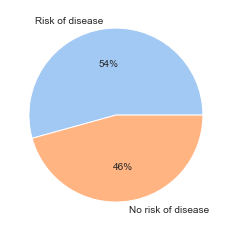

In [5]:
plt.pie(
    df["output"].value_counts(normalize=True),
    labels=['Risk of disease', 'No risk of disease'],
    colors= sns.color_palette('pastel')[:2],
    autopct='%.0f%%'
    )
plt.show()

### Variables Distributions

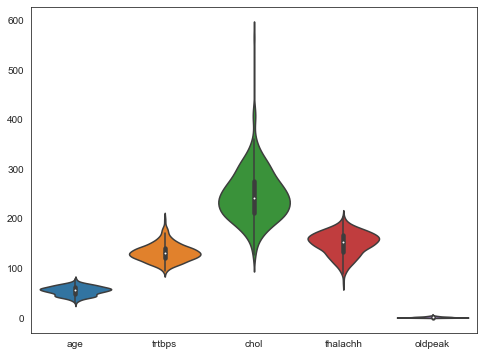

In [6]:
plt.figure(figsize=(8,6))
sns.violinplot(data=df, scale='count')
plt.show()

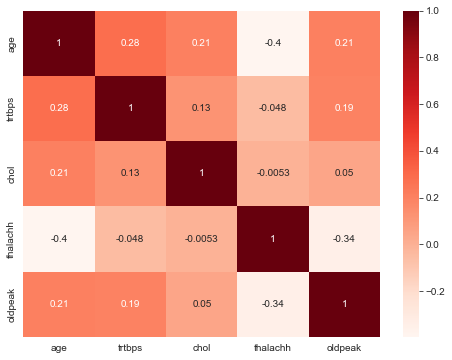

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(),
            annot=True,
            cmap='Reds')
plt.show()

# Splitting the data

In [8]:
X = df.drop(["output"], axis=1)
y = df["output"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Creating helpful functions

In [9]:
def create_model(algorithm, param_grid={}, metric='accuracy',
                 X_train=X_train, y_train=y_train, cv=5):
    
    global num_features, cat_features
    
    num_features_model = [i for i in num_features if i in X_train.columns]
    cat_features_model = [i for i in cat_features if i in X_train.columns]
    
    name = 'algorithm'
    if param_grid:
        param_grid = {name + '__' + k : v for k,v in param_grid.items() if name + '__' not in k}
    
    # Preprocess Numerical columns
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ])

    # Preprocess Categorical columns
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=True)),
        ])

    column_transformer = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, num_features_model),
            ('categorical', categorical_transformer, cat_features_model),
        ])

    model = imbpipeline(steps=[('column_transformer', column_transformer),
                               (name, algorithm),
                              ])
    
    
    grid_search = GridSearchCV(model,
                               param_grid=param_grid,
                               scoring=metric,
                               n_jobs=-1,
                               cv=cv)
    
    grid_search.fit(X_train, y_train)
                            
    return grid_search

In [10]:
def plot_confusion_matrix(matrix):
    """Plots a complete confusion matrix for binary classification problems"""
    
    # Confusion matrix for binary data
    tags = ['True Neg','False Pos','False Neg','True Pos']
    labels = [f'{tag}\n{value}\n{np.round(value/np.sum(matrix.ravel()) * 100, 2)}%'
              for tag, value in zip(tags, matrix.ravel())]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrix, annot=labels, cmap='Blues', fmt='')
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('Original', fontsize=10)

    plt.show()

In [11]:
def evaluate_model(model, conf_matrix=True, X_test=X_test, y_test=y_test):
    """Receives a trained model and evaluate its performance on test data"""
    
    y_pred = model.predict(X_test)
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)))
    if conf_matrix:
        plot_confusion_matrix(confusion_matrix(y_test, y_pred))
    try:
        print(f'Best Params: {model.best_params_}')
    except:
        pass

### One of the most important parts when we create a machine learning model is to define the <u>metric</u> that we want to optimize.
#### Since our problem is about health our classes don't have the same importance (It is not as harmful to predict that someone is at risk when they are not, compared to predicting that someone is not at risk when in fact they are) so we <span style="color:#f55a42">shouldn't use accuracy as a metric to evaluate performance</span><br>
### We need a metric that reduces the false negative so let's go with <span style="color:#1e1ee6">F1</span>

### Creating a Dummy Classifier that only predicts the most frequent class to have a base line to our models performance

In [12]:
y_pred_dummy = np.ones(shape=(y_test.shape))
f1_score(y_test, y_pred_dummy)

0.6881720430107526

# Automating the algorithms tests

In [13]:
def classification_fast_tests(metric='accuracy'):
    
    """The purpose of this function is to perform
    a fast test using the most commom classifiers.
    Some of them are heavily dependent on
    hyperparameters - so we will give them some
    After that we can pick only the top algorithms
    and make an larger hyperparameter search."""
    
    metrics = {'accuracy':'accuracy_score',
               'recall':'recall_score',
               'precision':'precision_score',
               'f1':'f1_score'}
    
    algorithms = ['LogisticRegression', 'GaussianNB', 'RandomForestClassifier',
                  'SVC', 'KNeighborsClassifier']
    
    
    LogisticRegression_params = {'C':[i for i in np.logspace(-1, 1, 3)]}
    GaussianNB_params = {}
    RandomForestClassifier_params = {}
    SVC_params = {'C':[i for i in np.logspace(-1, 1, 3)],
                  'gamma':[i for i in np.logspace(-1, 1, 3)]}
    KNeighborsClassifier_params = {'n_neighbors':[i*2 for i in range(10)]}
    
    parameters = [LogisticRegression_params, GaussianNB_params, RandomForestClassifier_params,
                 SVC_params, KNeighborsClassifier_params]
    
    results = {}
    for params, algorithm in zip(parameters, algorithms):
        model = create_model(algorithm=eval(algorithm)(),
                             param_grid=params,
                             metric=metric,
                             cv=3,
                            )
        
        y_pred = model.predict(X_test)
        
        
        performance = eval(metrics[metric])(y_test, y_pred)
        results[algorithm] = performance
        
    results = (pd.DataFrame.from_dict(
                                     results, orient='index', columns=[metric])
               .sort_values(by=metric, ascending=False))
    
    return results
classification_fast_tests(metric='f1')

,f1
SVC,0.918033
KNeighborsClassifier,0.918033
LogisticRegression,0.888889
RandomForestClassifier,0.838710
GaussianNB,0.680000


# It's pretty safe to choose SVC and KNeighbors to hypertune - both had a good cross-validation performance - so let's try them with our test data

,0,1,accuracy,macro avg,weighted avg
precision,0.843750,0.931034,0.885246,0.887392,0.889539
recall,0.931034,0.843750,0.885246,0.887392,0.885246
f1-score,0.885246,0.885246,0.885246,0.885246,0.885246
support,29.000000,32.000000,0.885246,61.000000,61.000000


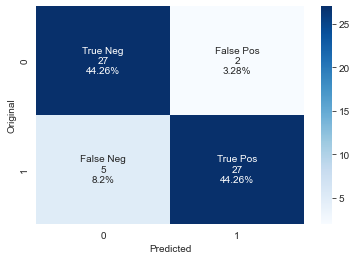

Best Params: {'algorithm__n_neighbors': 24, 'algorithm__weights': 'distance'}


In [14]:
param_grid ={'n_neighbors':[i*2 for i in range(1,50)],
                                'weights':['uniform', 'distance'],}

# fitting on our dataset
knn = create_model(algorithm=KNeighborsClassifier(n_jobs=-1),
                    param_grid=param_grid,
                    metric='f1'
                    )

evaluate_model(knn)

,0,1,accuracy,macro avg,weighted avg
precision,0.875000,0.965517,0.918033,0.920259,0.922484
recall,0.965517,0.875000,0.918033,0.920259,0.918033
f1-score,0.918033,0.918033,0.918033,0.918033,0.918033
support,29.000000,32.000000,0.918033,61.000000,61.000000


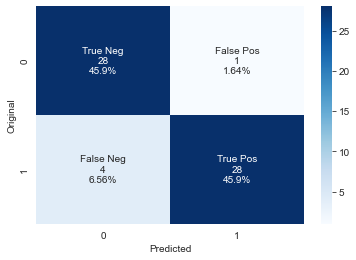

Best Params: {'algorithm__C': 1.0, 'algorithm__gamma': 0.1}


In [15]:
param_grid = {'C':[i for i in np.logspace(-6, 0, 7)],
              'gamma':[i for i in np.logspace(-6, 0, 7)],
             }

svm = create_model(algorithm=SVC(probability=True),
                    param_grid=param_grid,
                    metric='f1'
                    )

evaluate_model(svm)

# We lost some performance using KNN but we could achieve the same performance with SVC on the test data

# Finally we'll analyse the decision function threshold to choose the best value to improve our metric

In [16]:
def plot_thresholds(model, title, X_test=X_test, y_test=y_test):
    
    plt.figure(figsize=(8,6))
    metrics = ['accuracy_score', 'recall_score', 'precision_score', 'f1_score']
    results = {metric:{} for metric in metrics}

    for thresh in np.arange(0, 101)/100:
        proba = model.predict_proba(X_test)
        proba = np.where(proba[:,0]>thresh, 0, 1)

        for metric in metrics:
            results[metric][thresh] = (eval(metric)(y_test, proba))

    for metric in results:
        plt.plot(results[metric].keys(), results[metric].values(), label=metric)
    
    plt.ylim((0,1.1))
    plt.xlim((0,1))
    plt.xticks(np.arange(0, 100, 10)/100)
    plt.legend(loc='best')
    plt.title(title, fontsize=20)
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('Performance', fontsize=15)
    plt.show()
    
    for metric in results.keys():
        values = np.array(list(results[metric].values()))
        print(f'Best {metric} = {np.round(np.max(values), 2)}; Best Thresh = {np.argmax(values)}')

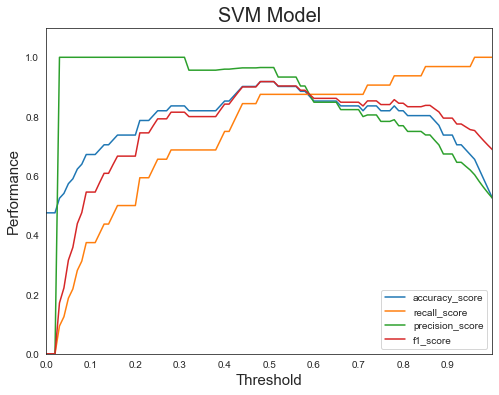

Best accuracy_score = 0.92; Best Thresh = 48
Best recall_score = 1.0; Best Thresh = 96
Best precision_score = 1.0; Best Thresh = 3
Best f1_score = 0.92; Best Thresh = 48


In [17]:
plot_thresholds(svm, 'SVM Model')

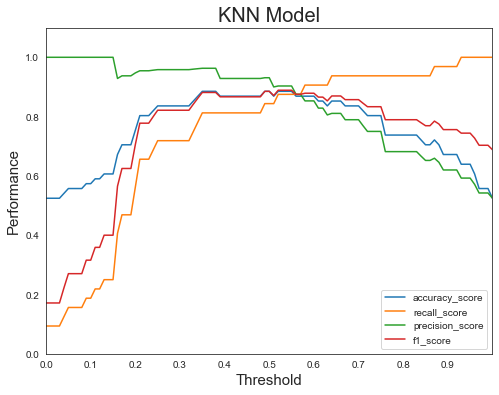

Best accuracy_score = 0.89; Best Thresh = 35
Best recall_score = 1.0; Best Thresh = 93
Best precision_score = 1.0; Best Thresh = 0
Best f1_score = 0.89; Best Thresh = 52


In [18]:
plot_thresholds(knn, 'KNN Model')

# Conclusion:

In this simple example, we fastly made a Support Vector Machine model (SVC) that achieves 0.92 F1 Score making use of functions that automate our testings.